<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.3
# *KNN Classification*

**In this lab, we will:**
- Practice KNN classification on a dataset of NHL statistics.
- Predict the `diagnoosis` of a patient from predictor variables of your choice.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import *
from IPython.display import display

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
breast_cancer_csv = 'breast-cancer-wisconsin-data.csv'
# breast_cancer_csv = 'breast-cancer-wisconsin-data.csv'
breast_cancer = pd.read_csv(breast_cancer_csv, index_col='id')
breast_cancer = breast_cancer.drop('Unnamed: 32', axis=1)

### 2. EDA 

Explore dataset. Clean data. Find correlation. 

In [3]:
from itertools import combinations
from scipy import stats

In [4]:
def find_feature_correlations(df):
    
    """
    Find correlations between df features and convert to a format 
    with one feature1 vs. feature2 correlation value per row 
    
    _Params:_
    
    df: pandas DataFrame, features as columns. All datatypes must be numeric
    
    Returns a pandas DataFrame where a row contains one feature1 vs. feature2 correlation value
    """
    
    # initalise variable lists 
    var1 = []
    var2 = []
    pearsons = []
    
    # iterate over generator for tuples of feature combination pairs
    for comb in combinations(df.columns.tolist(), 2):
        
        v1 = comb[0] 
        var1.append(v1) # save feature 1 to list 

        v2 = comb[1]
        var2.append(v2) # save feature 2 to list
        
        p, _ = stats.pearsonr(df[v1], df[v2]) # get pearson correlation
        pearsons.append(p)
    
    # Build dataframe of feature1 vs. feature2 pearson correlation
    corr_df = pd.DataFrame({'Feature1': var1,
                            'Feature2': var2,
                            'P': pearsons})
    
    return corr_df

In [5]:
def find_feature_correlations_w(df):
    
    """
    Find correlations between df features and convert to a format 
    with one feature1 vs. feature2 correlation value per row 
    
    _Params:_
    
    df: pandas DataFrame, features as columns. All datatypes must be numeric
    
    Returns a pandas DataFrame where a row contains one feature1 vs. feature2 correlation value
    """
    
    corr = df.select_dtypes(np.number).corr() # df is the pandas dataframe
    c1 = corr.abs().unstack() # Create a data frame
    c1 = pd.DataFrame(c1)
    c1 = c1.reset_index()
    c1.columns = ['Feature 1', 'Feature 2', 'P']
    mask = pd.DataFrame(np.sort(c1[['Feature 1','Feature 2']], axis=1), index=c1.index).duplicated()
    corr_df = c1[~mask]
    corr_df
    
    return corr_df

In [6]:
combinations(breast_cancer.columns.tolist(), 2)

In [7]:
find_feature_correlations(breast_cancer.select_dtypes(np.number))

,Feature1,Feature2,P
0,radius_mean,texture_mean,0.323782
1,radius_mean,perimeter_mean,0.997855
2,radius_mean,area_mean,0.987357
3,radius_mean,smoothness_mean,0.170581
4,radius_mean,compactness_mean,0.506124
...,...,...,...
430,concavity_worst,symmetry_worst,0.532520
431,concavity_worst,fractal_dimension_worst,0.686511
432,concave points_worst,symmetry_worst,0.502528
433,concave points_worst,fractal_dimension_worst,0.511114


In [8]:
breast_cancer.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [9]:
# See the correlations in descending order

corr = breast_cancer.select_dtypes(np.number).corr() # df is the pandas dataframe
c1 = corr.abs().unstack()
c1 = pd.DataFrame(c1)
c1 = c1.reset_index()
c1.columns = ['Feature 1', 'Feature 2', 'P']
result_df = c1.drop_duplicates(subset=['Feature 1', 'Feature 2'], keep='first')
result_df

,Feature 1,Feature 2,P
0,radius_mean,radius_mean,1.000000
1,radius_mean,texture_mean,0.323782
2,radius_mean,perimeter_mean,0.997855
3,radius_mean,area_mean,0.987357
4,radius_mean,smoothness_mean,0.170581
...,...,...,...
895,fractal_dimension_worst,compactness_worst,0.810455
896,fractal_dimension_worst,concavity_worst,0.686511
897,fractal_dimension_worst,concave points_worst,0.511114
898,fractal_dimension_worst,symmetry_worst,0.537848


In [10]:
mask = pd.DataFrame(np.sort(result_df[['Feature 1','Feature 2']], axis=1), index=result_df.index).duplicated()

df1 = result_df[~mask]
df1

,Feature 1,Feature 2,P
0,radius_mean,radius_mean,1.000000
1,radius_mean,texture_mean,0.323782
2,radius_mean,perimeter_mean,0.997855
3,radius_mean,area_mean,0.987357
4,radius_mean,smoothness_mean,0.170581
...,...,...,...
838,concave points_worst,symmetry_worst,0.502528
839,concave points_worst,fractal_dimension_worst,0.511114
868,symmetry_worst,symmetry_worst,1.000000
869,symmetry_worst,fractal_dimension_worst,0.537848


In [11]:
# Head
breast_cancer.head().T

id,842302,842517,84300903,84348301,84358402
diagnosis,M,M,M,M,M
radius_mean,17.99,20.57,19.69,11.42,20.29
texture_mean,10.38,17.77,21.25,20.38,14.34
perimeter_mean,122.8,132.9,130.0,77.58,135.1
area_mean,1001.0,1326.0,1203.0,386.1,1297.0
smoothness_mean,0.1184,0.08474,0.1096,0.1425,0.1003
compactness_mean,0.2776,0.07864,0.1599,0.2839,0.1328
concavity_mean,0.3001,0.0869,0.1974,0.2414,0.198
concave points_mean,0.1471,0.07017,0.1279,0.1052,0.1043
symmetry_mean,0.2419,0.1812,0.2069,0.2597,0.1809


In [45]:
# Check Shape of dataframe
print(f'(Rows, Columns) :')
breast_cancer.shape

(Rows, Columns) :


(569, 31)

In [13]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [14]:
# Check for null values of dataframe
breast_cancer.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

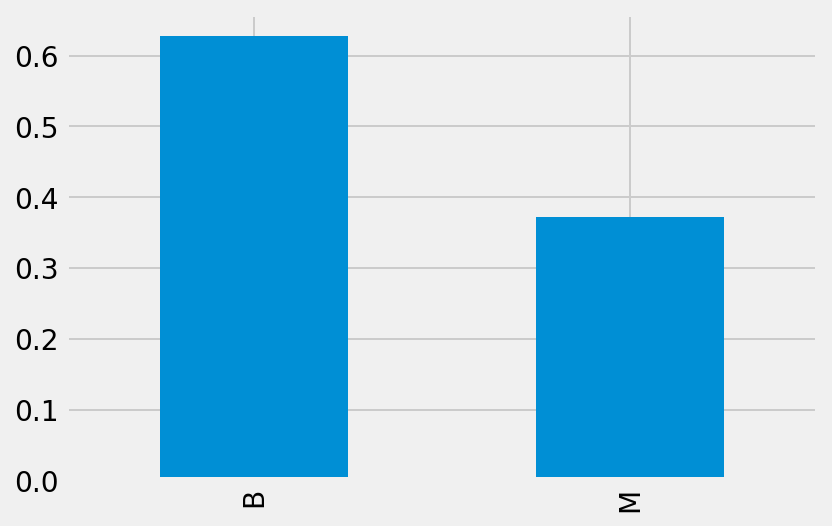

In [15]:
# Create bar plot of diagnosis column:
plt.style.use('fivethirtyeight')
breast_cancer['diagnosis'].value_counts(normalize=True).plot(kind='bar');

In [16]:
# Pair Plot
# sns.pairplot(breast_cancer, hue = )

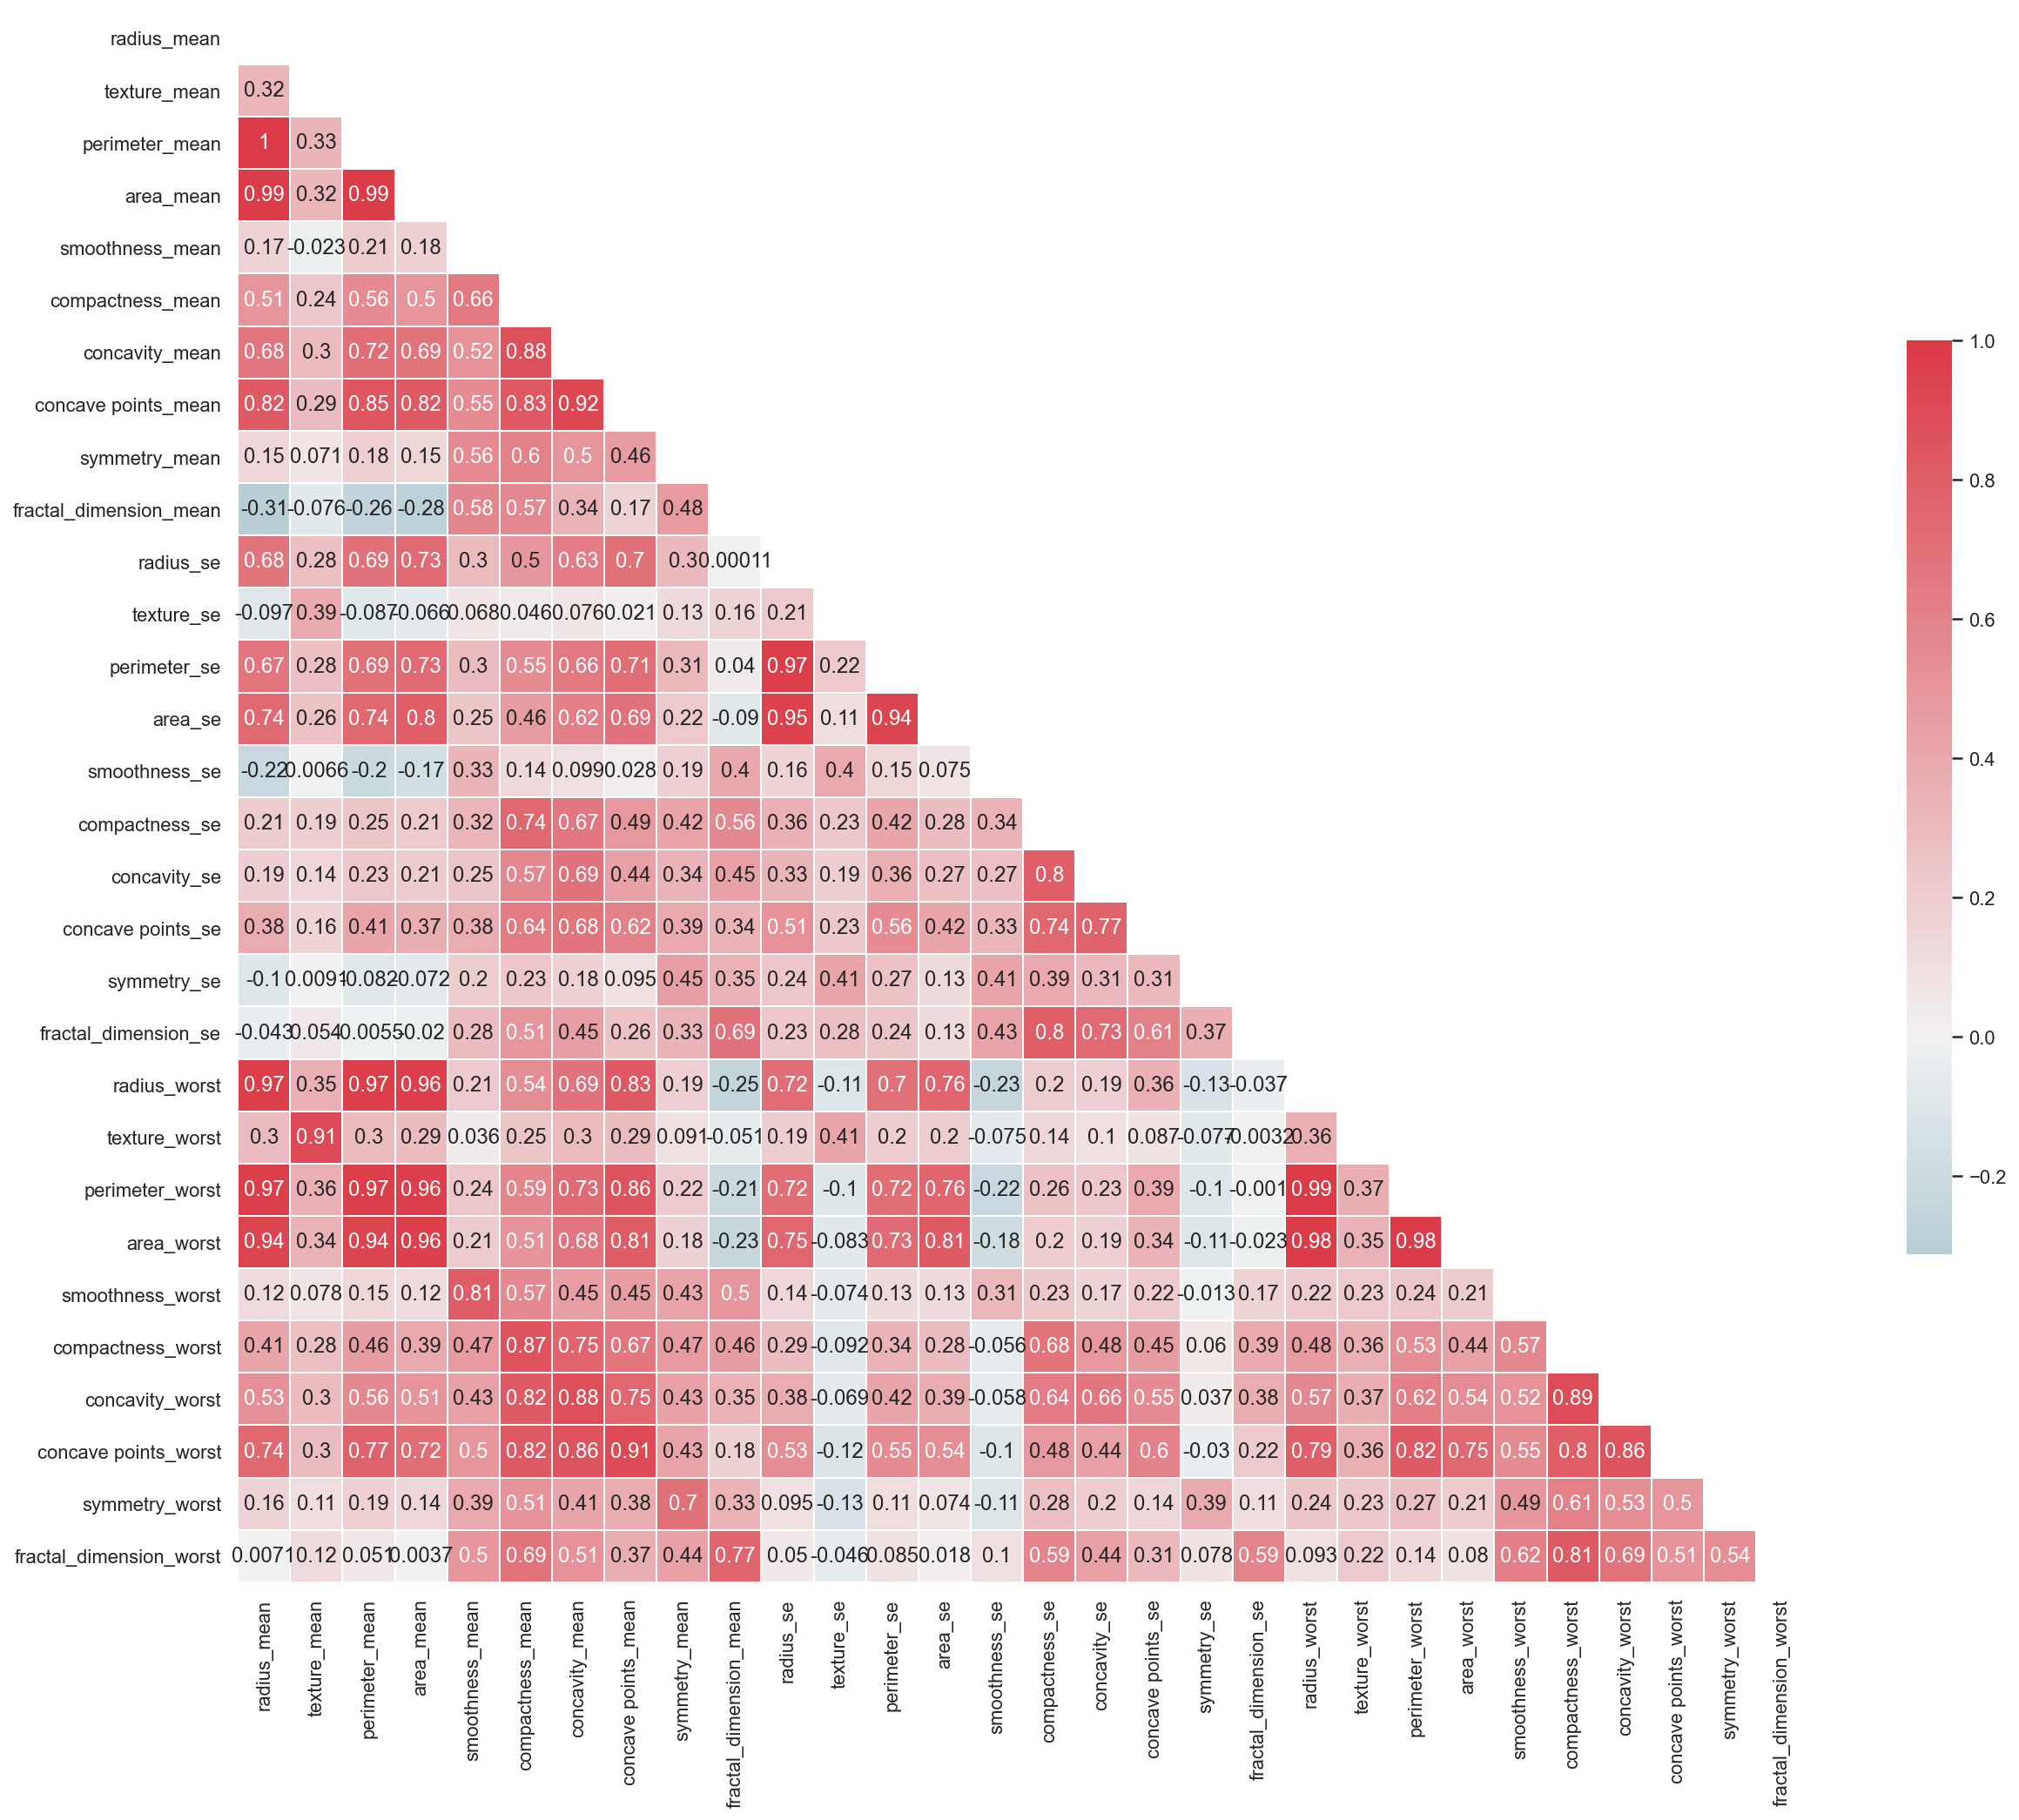

In [17]:
# Copied code from seaborn examples
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(breast_cancer.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(breast_cancer.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

In [18]:
# breast_cancer = breast_cancer[[c for c in breast_cancer.columns if not '_worst' in c and not '_se' in c]]
# breast_cancer.head(2).T

In [19]:
# sns.pairplot(breast_cancer)

### 3. Set up the `diagnosis` variable as your target. How many classes are there?

In [20]:
target_column = 'diagnosis'

In [21]:
y = breast_cancer[target_column]

### 4. What is the baseline accuracy?

In [22]:
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

### 5. Choose features to be your predictor variables and set up your X.

In [23]:
feature_columns = [c for c in breast_cancer.columns if c != 'diagnosis']
X = breast_cancer[feature_columns]

### 6. Fit a `KNeighborsClassifier` with 1 neighbor using the target and predictors.

In [24]:
from sklearn.neighbors import KNeighborsClassifier
# make an instance of a KNeighborsClassifier object with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# fit on the unstandardized data:
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

### 7. Evaluate the accuracy of your model.
- Is it better than baseline?
- Is it legitimate?

In [25]:
# predict the response values for the observations in X ("test the model")
# store the predicted response values
y_pred_class = knn.predict(X)

# compute classification accuracy
from sklearn import metrics

print(metrics.accuracy_score(y, y_pred_class))

1.0


In [26]:
print('Accuracy is : ', knn.score(X, y))

Accuracy is :  1.0


### 8. Create a 80-20 train-test-split of your target and predictors. Refit the KNN and assess the accuracy.

In [27]:
from sklearn.model_selection import train_test_split

# STEP 1: split X and y into training and testing sets (using random_state=42 for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# STEP 2: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9298245614035088


In [28]:
print('Accuracy is : ', knn.score(X_test, y_test))

Accuracy is :  0.9298245614035088


### 9. Evaluate the test accuracy of a KNN where K == number of rows in the training data.

In [29]:
X_train.shape[0]

455

In [30]:
knn = KNeighborsClassifier(n_neighbors=X_train.shape[0])
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.6228070175438597


In [31]:
print('Accuracy is : ', knn.score(X_test, y_test))

Accuracy is :  0.6228070175438597


### 10. Fit the KNN at values of K from 1 to the number of rows in the training data.
- Store the test accuracy in a list.
- Plot the test accuracy vs. the number of neighbors.

In [32]:
# fit the KNN from 1 to no. of rows
test_acc = []
for i in range(1, X_train.shape[0]+1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    test_acc.append(knn.score(X_test, y_test))

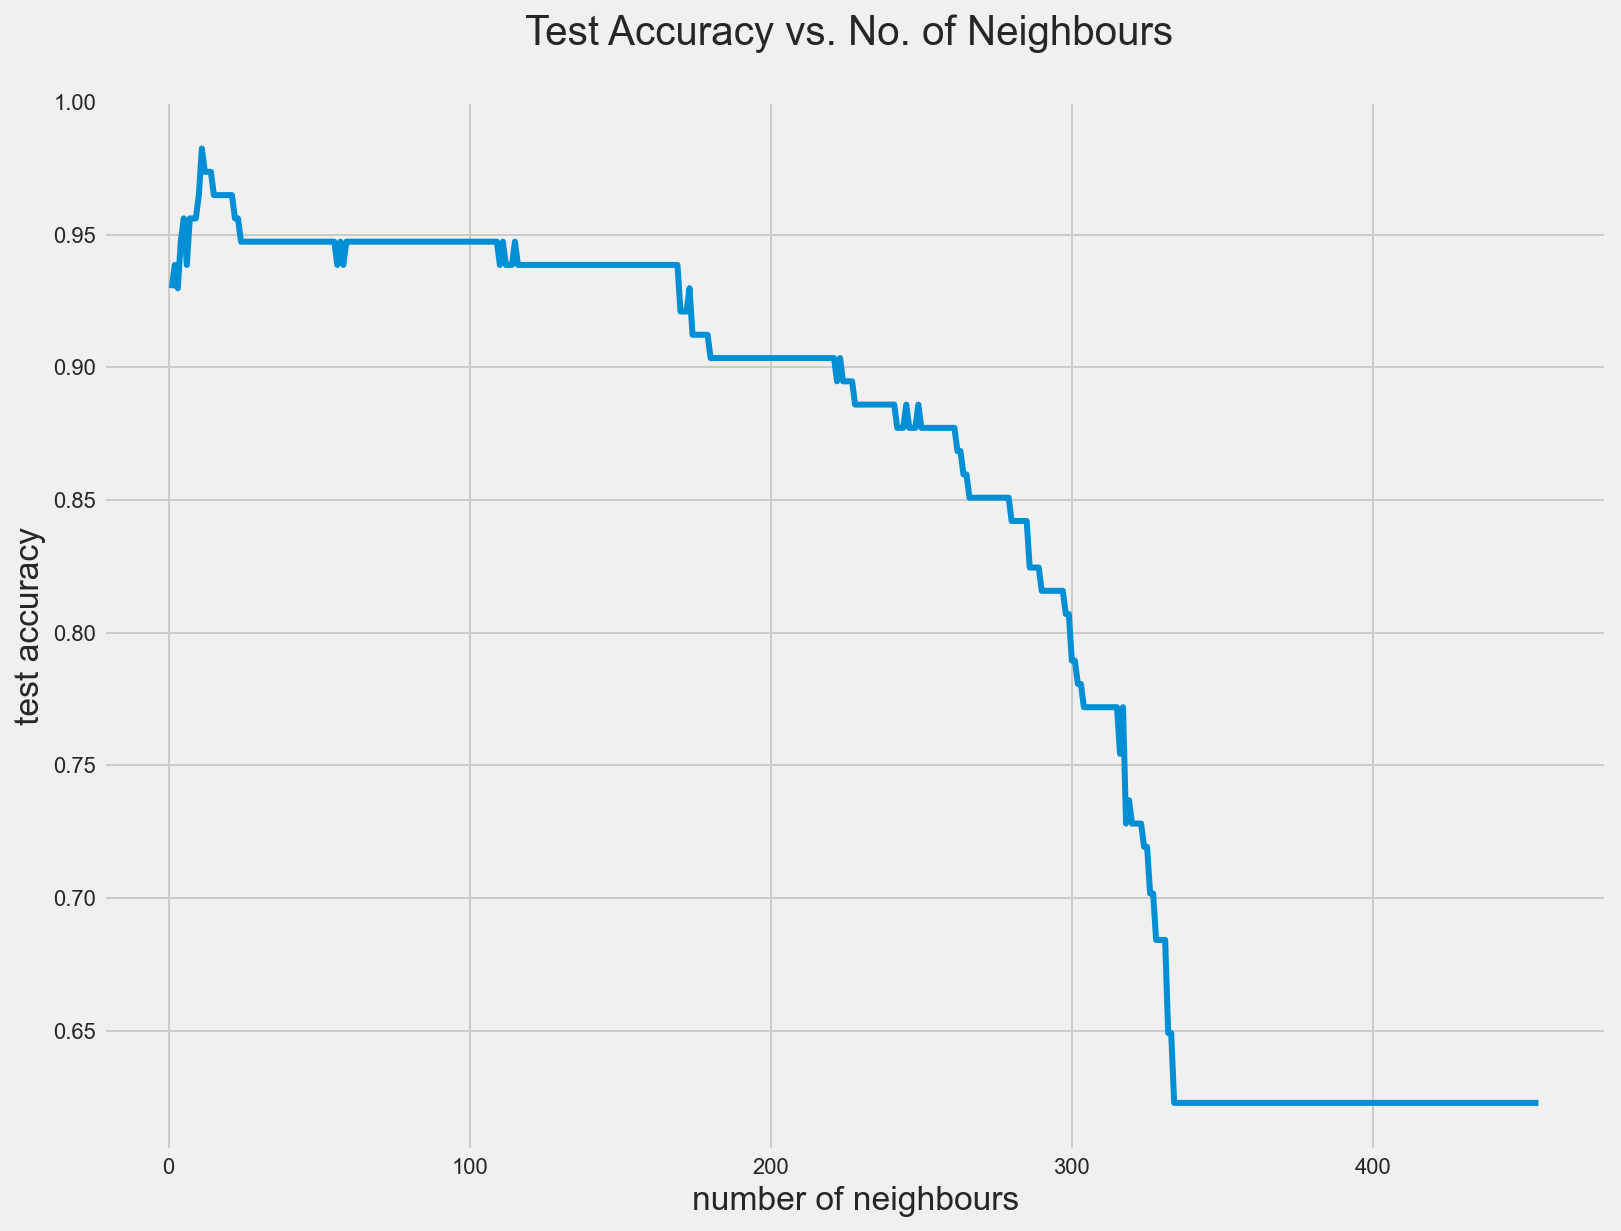

In [33]:
# plot test accuracy by number of neighbors:

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(list(range(1, X_train.shape[0]+1)), test_acc, lw=3)
ax.set(title='Test Accuracy vs. No. of Neighbours \n', xlabel='number of neighbours', ylabel='test accuracy');
plt.show()

### 11. Fit KNN across different values of K and plot the mean cross-validated accuracy with 5 folds.


In [34]:
from sklearn.model_selection import cross_val_score

folds = 5
max_neighbors = np.floor(X.shape[0] - X.shape[0]/5)

print('Max. no. of neighbours : ', max_neighbors)

# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    test_acc.append(np.mean(cross_val_score(knn, X, y, cv=folds)))
    
print('Highest test accuracy : ', max(test_acc))

Max. no. of neighbours :  455.0
Highest test accuracy :  0.935010091600683


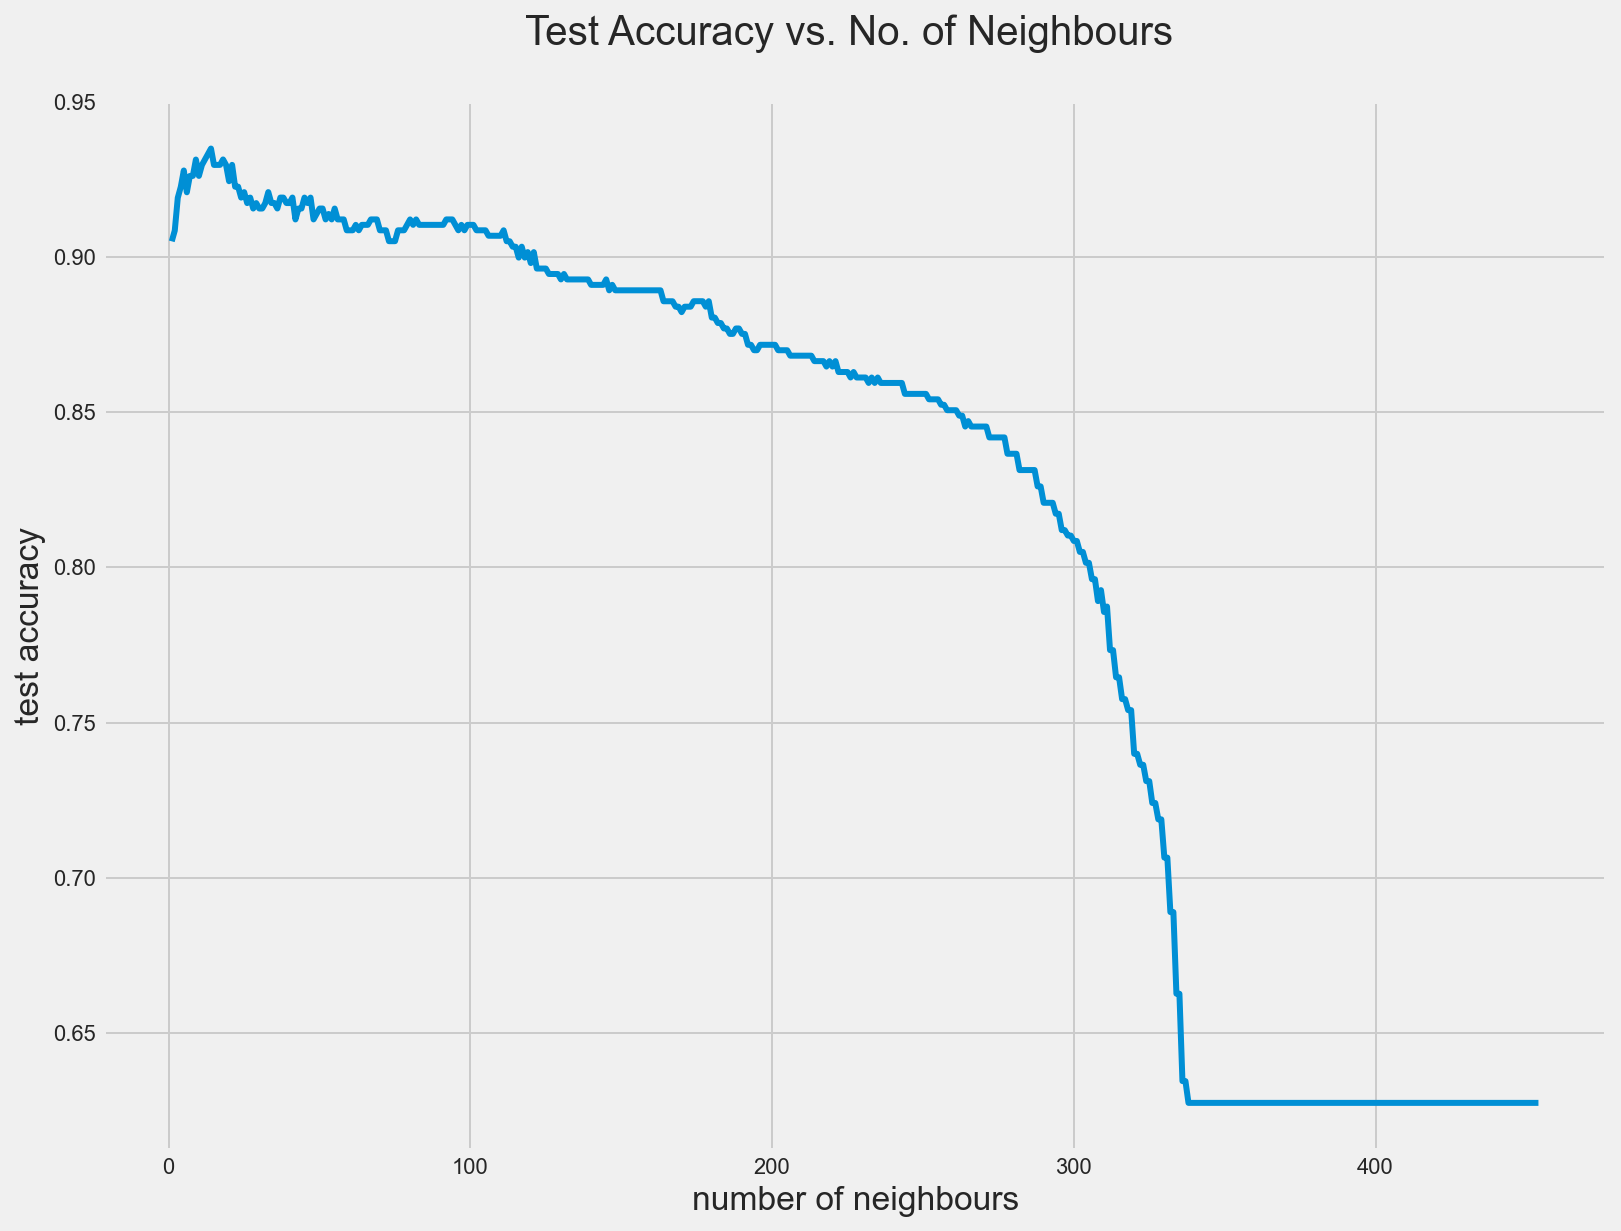

In [35]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(list(range(1, int(max_neighbors))), test_acc, lw=3)
ax.set(title='Test Accuracy vs. No. of Neighbours \n', xlabel='number of neighbours', ylabel='test accuracy');
plt.show()

### 12. Standardize the predictor matrix and cross-validate across the different K.
- Plot the standardized mean cross-validated accuracy against the unstandardized. Which is better?
- Why?

In [36]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [37]:
pd.DataFrame(Xs).describe().T

,count,mean,std,min,25%,50%,75%,max
0,569.0,-1.256562e-16,1.00088,-2.029648,-0.689385,-0.215082,0.469393,3.971288
1,569.0,1.049736e-16,1.00088,-2.229249,-0.725963,-0.104636,0.584176,4.651889
2,569.0,-1.272171e-16,1.00088,-1.984504,-0.691956,-0.235980,0.499677,3.976130
3,569.0,-1.900452e-16,1.00088,-1.454443,-0.667195,-0.295187,0.363507,5.250529
4,569.0,-8.226187e-16,1.00088,-3.112085,-0.710963,-0.034891,0.636199,4.770911
5,569.0,2.419467e-16,1.00088,-1.610136,-0.747086,-0.221940,0.493857,4.568425
6,569.0,-1.315097e-16,1.00088,-1.114873,-0.743748,-0.342240,0.526062,4.243589
7,569.0,-8.780323e-17,1.00088,-1.261820,-0.737944,-0.397721,0.646935,3.927930
8,569.0,1.957036e-16,1.00088,-2.744117,-0.703240,-0.071627,0.530779,4.484751
9,569.0,5.073075e-16,1.00088,-1.819865,-0.722639,-0.178279,0.470983,4.910919


In [38]:
# plot test accuracy by number of neighbors:
test_acc_std = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    test_acc_std.append(np.mean(cross_val_score(knn, Xs, y, cv=5)))

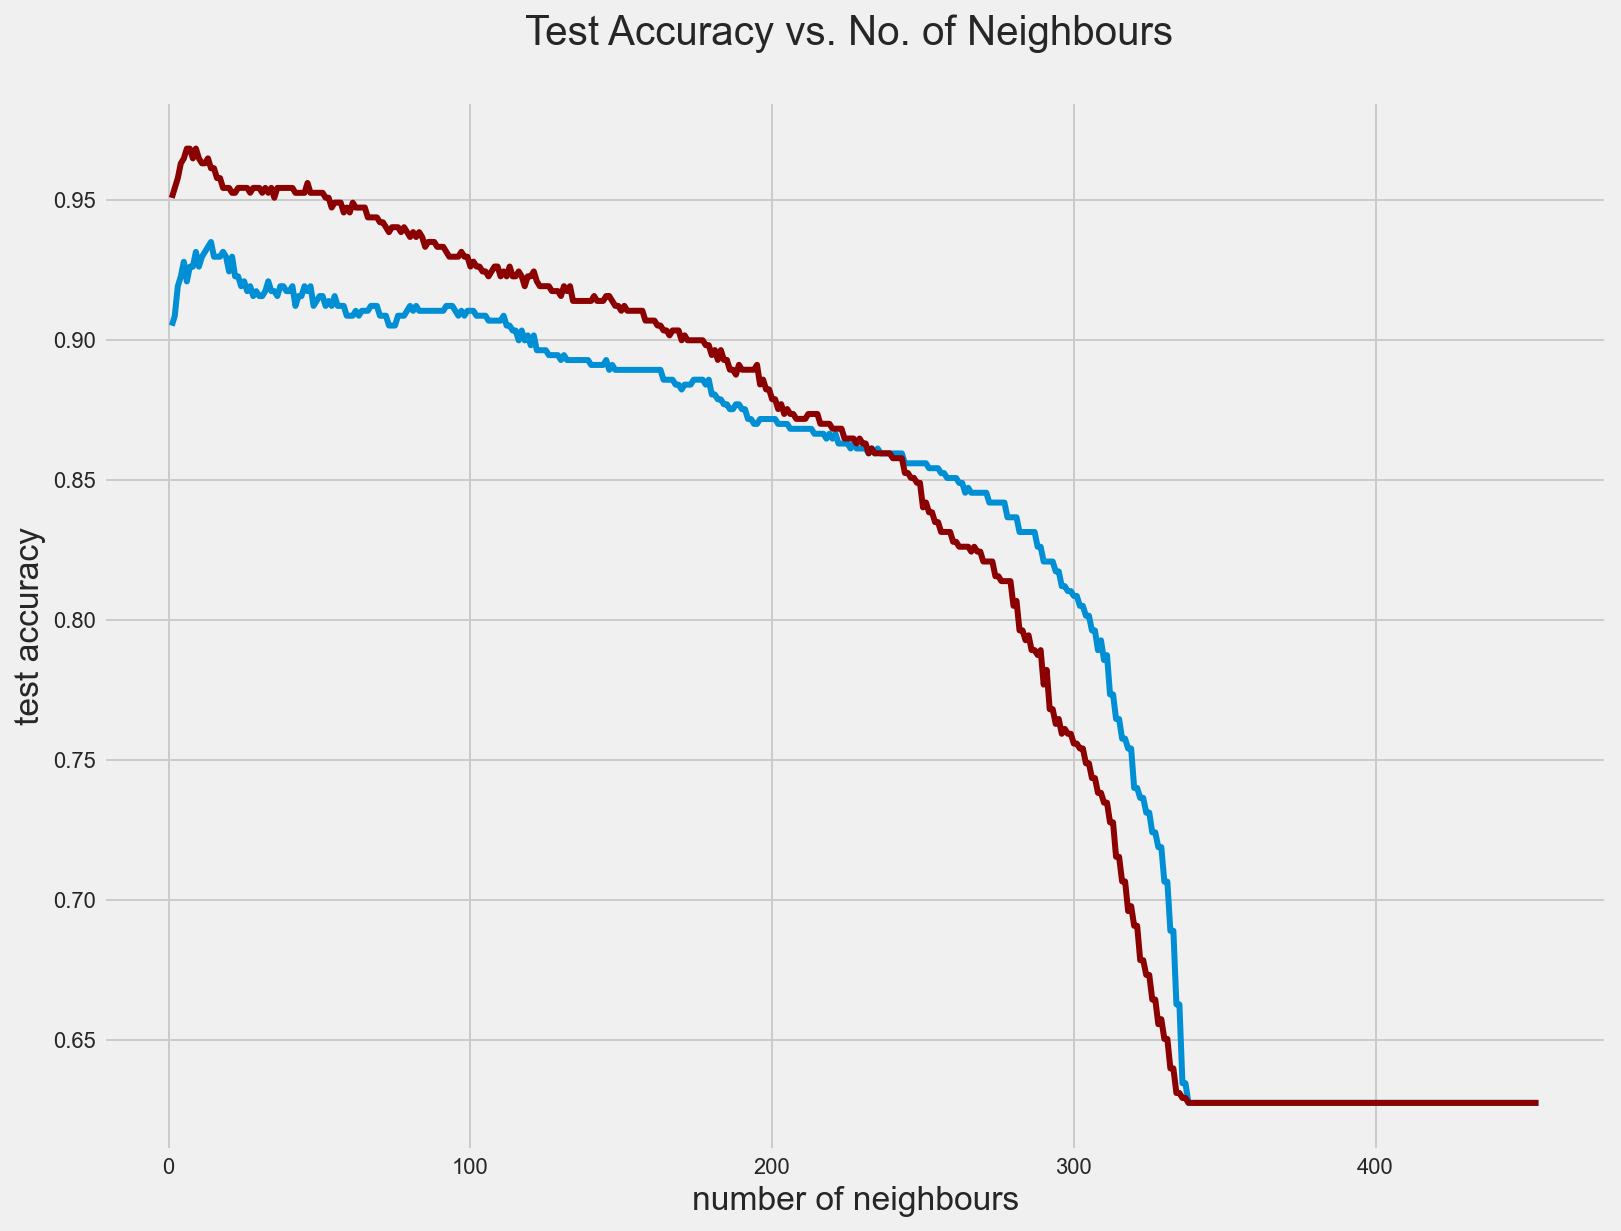

In [39]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(list(range(1, int(max_neighbors))), test_acc, lw=3)
ax.plot(list(range(1, int(max_neighbors))), test_acc_std, lw=3, color='darkred')
ax.set(title='Test Accuracy vs. No. of Neighbours \n', xlabel='number of neighbours', ylabel='test accuracy');
plt.show()

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



